In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
your_folder_path = "/content/drive/MyDrive/Thesis/Implement/Data/Data/Camp"
os.chdir(your_folder_path)

Import necessary libraries

In [6]:
!pip install scanpy -q

In [7]:
import pandas as pd
import numpy as np
import scanpy as sc

**DATA**
- iPS = induced pluripotent stem cells (day 0)
- HE = hepatic endoderm (day 8)
- LB = liver bud = hepatic endoderm + supportive mesenchymal and endothelial cells
- MH = mature hepatocyte-like (day 21)
- DE = definitive endoderm (day 6)
- IH = immature hepatoblast-like (day 14)
- EC = endothelial cells
- HUVEC = human umbilical vein endothelial cells
- msc = mesenchymal stem cell

Load dataset, set index, and transpose for compatibility with scanpy

In [8]:
x1 = pd.read_csv("GSE81252_data.cast.log2.lineage.csv", sep=",", index_col=0)
experiment1 = x1.iloc[:, 0]  # Extract experiment info
x1 = x1.iloc[:, 2:]          # Remove first two columns (ID and experiment info)
x1 = x1.transpose()

x2 = pd.read_csv("GSE81252_data.cast.log2.liverbud.csv", sep=",", index_col=0)
experiment2 = x2.iloc[:, 0]      # Extract experiment info
assignment2 = x2.iloc[:, 1]      # Extract assignment info
x2 = x2.iloc[:, 3:]              # Remove first three columns (ID, experiment info, assignment info)
x2 = x2.transpose()

Check duplicate cells and remove them from x1 if they exist in x2

In [9]:
dups = x1.columns[x1.columns.isin(x2.columns)]
for col in dups:
    if not (x1[col] == x2[col]).all():
        print(f"Duplicate with differences found: {col}")
x1 = x1.drop(columns=dups)
experiment1 = experiment1.drop(experiment1.index[experiment1.index.isin(dups)])

MAT = pd.concat([x1, x2], axis=1)

Create annotations for each dataset
\- Update types based on certain conditions

In [10]:
Stage = np.concatenate([experiment1, experiment2])
Type = np.concatenate([experiment1, assignment2])

Type = pd.Series(Type)

Type = Type.str.replace("ih", "immature hepatoblast", regex=True)
Type = Type.str.replace("mh", "mature hepatocyte", regex=True)
Type = Type.str.replace("de", "definitive endoderm", regex=True)
Type = Type.str.replace("EC", "endothelial", regex=True)
Type = Type.str.replace("HE", "hepatic endoderm", regex=True)
Type = Type.str.replace("MC", "mesenchymal stem cell", regex=True)

Type = Type.to_numpy()

Define Source annotation

In [11]:
Source1 = np.repeat("iPSC line TkDA3-4", len(experiment1))
Source2 = np.repeat("iPSC line TkDA3-4", len(experiment2))
Source2[experiment2 == "huvec"] = "HUVEC"
Source2 = np.where(experiment2.str.contains("lb"), "liver bud", Source2)
Source2 = np.where(experiment2.str.contains("msc"), "Mesenchymal stem cell", Source2)
Source = np.concatenate([Source1, Source2])

Create Age annotation

In [12]:
Age = np.copy(Stage).astype(str)

Age = np.where(np.char.find(Age, "de") != -1, "6 days", Age)
Age = np.where(np.char.find(Age, "ipsc") != -1, "0 days", Age)
Age = np.where(np.char.find(Age, "mh") != -1, "21 days", Age)
Age = np.where(np.char.find(Age, "he") != -1, "8 days", Age)
Age = np.where(np.char.find(Age, "lb") != -1, "liver bud", Age)
Age = np.where(np.char.find(Age, "ih") != -1, "14 days", Age)
Age = np.where(np.char.find(Age, "msc") != -1, "msc", Age)

Create Batch annotation

In [13]:
Batch = np.copy(Stage).astype(str)

Batch = np.where(np.char.find(Batch, "lb1") != -1, "3", Batch)
Batch = np.where(np.char.find(Batch, "lb2") != -1, "4", Batch)
Batch = np.where(np.char.find(Batch, "lb3") != -1, "5", Batch)
Batch = np.where(np.char.find(Batch, "lb4") != -1, "6", Batch)
Batch = np.where(np.char.find(Batch, "lb5") != -1, "7", Batch)
Batch = np.where(np.char.find(Batch, "lb6") != -1, "8", Batch)
Batch = np.where(np.char.find(Batch, "1") != -1, "1", Batch)
Batch = np.where(np.char.find(Batch, "2") != -1, "2", Batch)
Batch = np.where(np.char.find(Batch, "de") != -1, "9", Batch)
Batch = np.where(np.char.find(Batch, "ipsc") != -1, "10", Batch)
Batch = np.where(np.char.find(Batch, "huvec") != -1, "11", Batch)


Create AnnData object

In [14]:
annotations = pd.DataFrame({
    "Species": "Homo sapiens",
    "cell_type": Type,
    "Source": Source,
    "age": Age,
    "batch": Batch
}, index=MAT.columns)

In [15]:
print("MAT shape:", MAT.shape)             # Should output (genes, cells)
print("Annotations shape:", annotations.shape)  # Should output (cells, features)

MAT shape: (19019, 777)
Annotations shape: (777, 5)


In [16]:
adata = sc.AnnData(X=MAT.values.T)
adata.obs = annotations
adata.write("camp1.h5ad")

In [17]:
# Save the expression matrix into a CSV file
# Convert the expression matrix (adata.X) to a dense array if it's sparse
expression_matrix_dense = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

# Create a Pandas DataFrame from the expression matrix
# Use adata.obs_names for row index (cell names) and adata.var_names for column index (gene names)
expression_df = pd.DataFrame(
    expression_matrix_dense,
    index=adata.obs_names,
    columns=adata.var_names
)

# Save the DataFrame to a CSV file
expression_df.to_csv("expression_matrix.csv")

print("AnnData object saved to camp1.h5ad")
print("Expression matrix saved to expression_matrix.csv")

AnnData object saved to camp1.h5ad
Expression matrix saved to expression_matrix.csv


In [18]:
adata.obs

,Species,cell_type,Source,age,batch
cell_id,,,,,
A10_de,Homo sapiens,definitive endoderm,iPSC line TkDA3-4,6 days,9
A11_de,Homo sapiens,definitive endoderm,iPSC line TkDA3-4,6 days,9
A2_de,Homo sapiens,definitive endoderm,iPSC line TkDA3-4,6 days,9
A3_de,Homo sapiens,definitive endoderm,iPSC line TkDA3-4,6 days,9
A5_de,Homo sapiens,definitive endoderm,iPSC line TkDA3-4,6 days,9
...,...,...,...,...,...
H8_msc2,Homo sapiens,mesenchymal stem cell,Mesenchymal stem cell,msc,2
H9_huvec,Homo sapiens,endothelial,HUVEC,huvec,11
H9_lb3,Homo sapiens,hepatic endoderm-LB,liver bud,liver bud,5


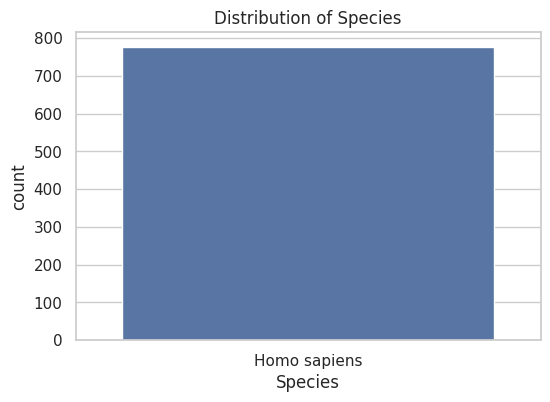

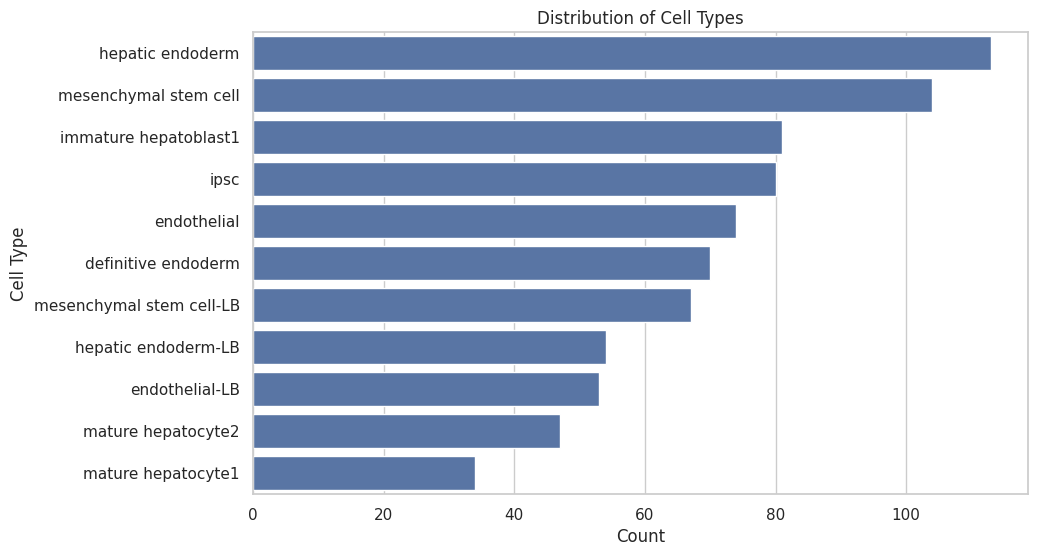

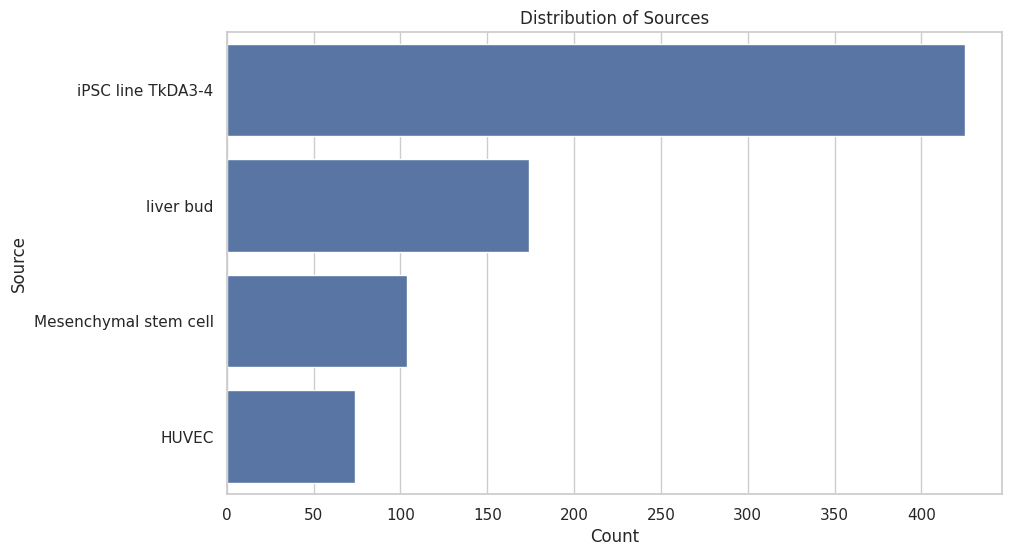

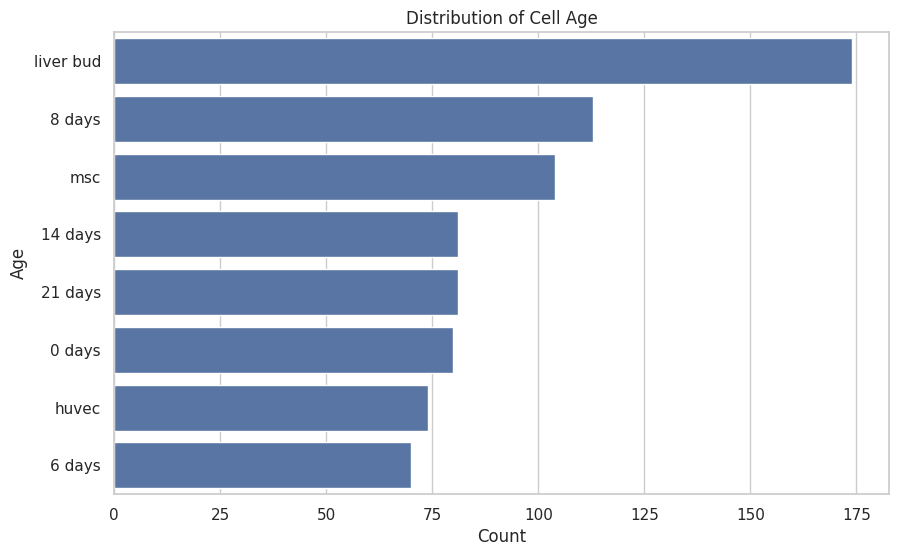

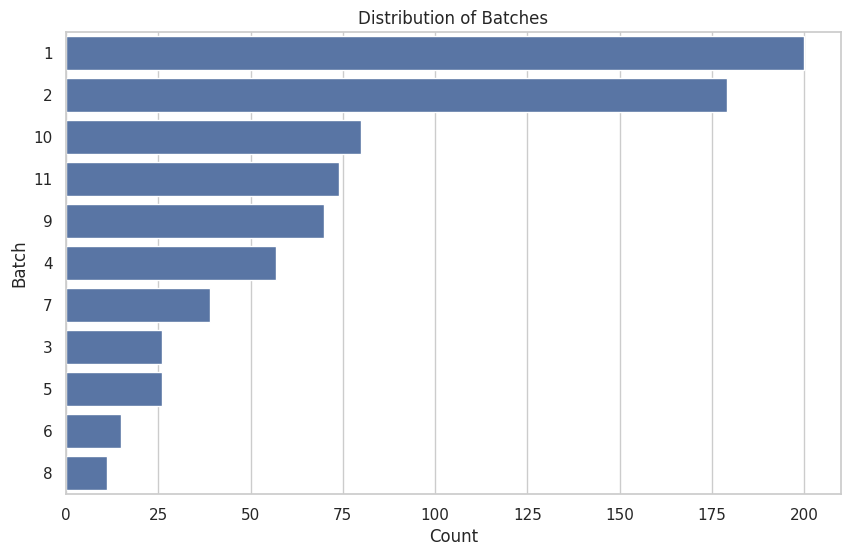

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for the plots
sns.set(style="whitegrid")

# Cell 1: Plot Species distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=adata.obs, x="Species")
plt.title("Distribution of Species")
plt.show()

# Cell 2: Plot Cell Type distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=adata.obs, y="cell_type", order=adata.obs['cell_type'].value_counts().index)
plt.title("Distribution of Cell Types")
plt.xlabel("Count")
plt.ylabel("Cell Type")
plt.show()

# Cell 3: Plot Source distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=adata.obs, y="Source", order=adata.obs['Source'].value_counts().index)
plt.title("Distribution of Sources")
plt.xlabel("Count")
plt.ylabel("Source")
plt.show()

# Cell 4: Plot Age distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=adata.obs, y="age", order=adata.obs['age'].value_counts().index)
plt.title("Distribution of Cell Age")
plt.xlabel("Count")
plt.ylabel("Age")
plt.show()

# Cell 5: Plot Batch distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=adata.obs, y="batch", order=adata.obs['batch'].value_counts().index)
plt.title("Distribution of Batches")
plt.xlabel("Count")
plt.ylabel("Batch")
plt.show()

In [20]:
def read_dataset(adata, transpose=False, copy=False, check_counts=True):
    if isinstance(adata, sc.AnnData):
        if copy:
            adata = adata.copy()
    elif isinstance(adata, str):
        adata = sc.read(adata)
    else:
        raise NotImplementedError

    adata.X = adata.X.astype(float)

    if transpose: adata = adata.transpose()
    return adata

DATASET = '/content/drive/MyDrive/Thesis/Implement/Experiment/Result/camp_res_20.h5ad'
adata_res = read_dataset(DATASET)

In [26]:
print(adata_res.obsm['X_infomax'])

[[ 2.7916636 -2.5246131]
 [ 2.988593  -2.9533765]
 [ 2.9885776 -2.8286567]
 ...
 [-1.4127817  3.1585474]
 [-3.4609923  5.267114 ]
 [-8.59464   -1.7964406]]
